## Plan

1. Problems of common Score Matching approaches

    1. The manifold hypothesis

    2. Ill-estimated score in low data density regions

    3. Slow Langevin Dynamics convergence

2. Solution: NCSN 

    1. Main idea: perturbing data expanding support of our distribution

    2. Objective

    3. Annealed Langevin dynamics

    4. How to choose hyperparameters?

3. Apply NCSN to toy example

In [2]:
import torch
import torch.nn as nn
import torch.distributions as TD
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, clear_output
from typing import Callable, Dict, List, Tuple, Union, Optional

## Problems of common Score Matching approaches

### The manifold hypothesis

It states that data in the real world tend to concentrate on low dimensional manifolds embedded in a high dimensional space. 

### Ill-estimated score in low data density regions

**Langevin Dynamics:**
$$
    x_t = x_{t - 1} +
    \frac{\epsilon}{2} \nabla_x \log\pi(x_{t - 1}) +
    \sqrt{\epsilon} z_t,
    \qquad
    z_t \sim \mathcal{N}(0, I)
$$
To sample from $\pi(x)$ we have to estimate $\nabla_x \log\pi(x_{t - 1})$ on whole $\mathbb{R}^D$.

**Score Matching objective:**
$$
    J_{ESM}(\theta) = \mathbb{E}_{\pi(x)} || s_\theta (x) - \nabla_x \log \pi (x) ||^2
$$

Pay your attention to the fact, that we estimate the score-function only nearby to our dataset,
which according to Manifold Hypothesis lies on a low dimensional manifold.

That means, that our trained score-model is ill-estimated at most of the $\mathbb{R}^D$.

As a result, starting from random point and using Langevin Dynamics we are highly probable to fail to converge to the given distribution.

In [3]:
Image(url="pics/ill_estimated_score.png", width=500)

### Slow Langevin Dynamics convergence

When two modes of the data distribution are separated by low density reegions, Langevin Dymamics will not be able to correctly recover the relative weights of these two modes in reasonable time, and therefore might not converge to the true distribution.

Consider a mixture distribution
$p_{data}(x) = \pi p_1(x) + (1 - \pi) p_2(x)$, where $p_1(x)$ and $p_2(x)$ are normalized distributions with disjoint supports, and $\pi \in (0, 1)$.

In the support of $p_1(x)$, $\nabla_x \log p_{data}(x) = \nabla_x (\log \pi + \log p_1(x)) = \nabla_x \log p_1(x)$, and in the support of $\nabla_x \log p_{data}(x) = \nabla_x (\log (1 - \pi) + \log p_2(x)) = \nabla_x \log p_2(x)$.

In either case, the score $\nabla_x \log p_{data}(x)$ does not depend on $\pi$.

Since Langevin Dynamics use $\nabla_x \log p_{data}(x)$ to sample from $p_{data}(x)$, the samples obtained will not depend on $\pi$.

In [ ]:
class GMM:
    def __init__(self, probs: List, mus: List[List], sigmas: List[List], device: str="cpu") -> None:
        assert sum(probs) == 1.
        assert len(probs) == len(mus) == len(sigmas)
        self.probs = torch.tensor(probs, device=device)
        self.mus = torch.tensor(mus, device=device)
        self.sigmas = torch.stack([
            torch.diag(torch.tensor(sigma, device=device))
            for sigma in sigmas
        ])

        self.gmm = TD.MixtureSameFamily(
            TD.Categorical(self.probs),
            TD.MultivariateNormal(self.mus, covariance_matrix=self.sigmas)
        )
    
    def sample(self, shape: Tuple) -> Tensor:
        return self.gmm.sample(shape)

    def log_prob(self, samples: Tensor) -> Tensor:
        return self.gmm.log_prob(samples)

    def prob(self, samples: Tensor) -> Tensor:
        return self.log_prob(samples).exp()
    
    def score(self, samples: Tensor) -> Tensor:
        with torch.enable_grad():
            samples = samples.detach()
            samples.requires_grad_(True)
            log_prob = self.log_prob(samples).sum()
            return torch.autograd.grad(log_prob, samples)[0]

In [6]:
class LangevinDynamics:
    def __init__(self, score_fn: Callable, step_size: Tensor) -> None:
        self.score_fn = score_fn
        self.step_size = step_size
    
    def step(self, xt: Tensor, **kwargs: Dict) -> Tensor:
        noise = torch.randn_like(xt)
        return (
            xt + 
            0.5 * self.step_size * self.score_fn(xt, **kwargs) +
            self.step_size.sqrt() * noise
        )

    def __call__(self, xt: Tensor, T: int, **kwargs) -> Tensor:
        for _ in range(T):
            xt = self.step(xt, **kwargs)
        return xt

In [7]:
probs = [0.8, 0.2]
mus = np.asarray([
    [-1., -1.],
    [1., 1.]
]) * 5
sigmas = np.asarray([
    [1., 1.],
    [1., 1.]
])
gmm = GMM(probs, mus, sigmas)

<Axes: xlabel='None', ylabel='None'>

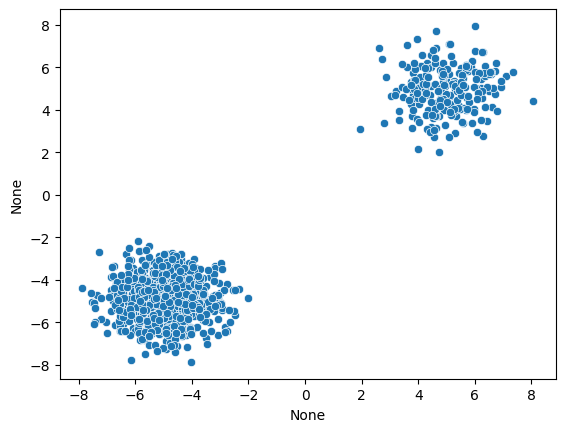

In [8]:
samples = gmm.sample((1000, ))
sns.scatterplot(x=samples[:, 0], y=samples[:, 1], )

In [9]:
score_fn = lambda x: gmm.score(x)
ld = LangevinDynamics(step_size=torch.tensor(0.01), score_fn=score_fn)

<Axes: xlabel='None', ylabel='None'>

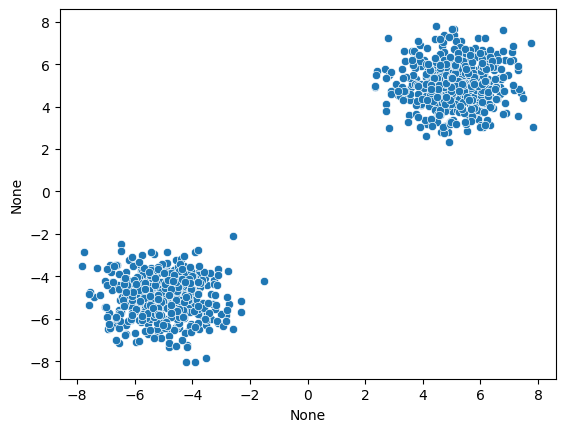

In [12]:
T = 1000
x_start = (torch.rand((1000, 2)) - 0.5) * 16.
generations = ld(x_start, T)
sns.scatterplot(x=generations[:, 0], y=generations[:, 1], )

## Solution: NCSN (Noise Conditioning Score Matching)

**Main idea** is perturbing data with Gaussian noise.

1. Since the support of Gaussian noise distribution is the whole space, the perturbed data will not be confined to a low dimensional manifold, which obviates difficulties from the manifold hypothesis and makes score estimation well-defined.

2. Large Gaussian noise has the effect of filling low density regions in the original unperturbed data distribution; therefore score matching may get more training signal to improve score estimation.

Let $\{\sigma_i\}_{i=1}^L$ be a geometric sequence, that satisfies
$\frac{\sigma_{i - 1}}{\sigma_i} = const > 1 \ \forall i$.

Let $q_{\sigma}(x) \coloneqq \int p_{data}(t) \mathcal{N}(x | t, \sigma^2 I)$.

We choose $\sigma_1$ large enough to mitigate aforementioned problems, and $\sigma_L$ such $p_{data}(x) \approx q_{\sigma_{L}}(x)$

We aim to estimate scores of all those distributions with a single model conditioned on a noise level, i.e. $s_{\theta}(x, \sigma) \approx \nabla_x \log q_\sigma(x)$.

This model is called Noise Conditioning Score Network.

### NCSN objective

Every score function will be learned using Denoising Score Matching objective:
$$
\begin{align}
    l(\theta, \sigma) &=
        \dfrac{1}{2}
        \mathbb{E_{p_{data}(x)}}
        \mathbb{E_{x' \sim \mathcal{N}(x, \sigma^2 I)}}
        \left\|
            s(\theta, \sigma)
            -
            \nabla_{x'} \log q(x' | x, \sigma I)
        \right\|^2\\
        &=
        \dfrac{1}{2}
        \mathbb{E_{p_{data}(x)}}
        \mathbb{E_{x' \sim \mathcal{N}(x, \sigma^2 I)}}
        \left\|
            s(\theta, \sigma)
            +
            \dfrac{x' - x}{\sigma^2}
        \right\|^2
\end{align}
$$

So, the resulting objective has the following view:
$$
\begin{align}
    L(\theta, \{\sigma_i\}_{i=1}^L) =
        \dfrac{1}{L}
        \sum_{i = 1}^{L}
        \lambda(\sigma_i)
        l(\theta, \sigma_i).
\end{align}
$$


How to choose $\lambda(\sigma)$?

It was empirically shown, that trained model $\|s_{\theta}(x, \sigma)\| \propto \frac{1}{\sigma}$.

So, we can choose $\lambda(\sigma) = \sigma^2$ in order to make every additive in loss independent of $\sigma$:
$$
    \lambda(\sigma) l(\theta, \sigma)
        =
        \dfrac{1}{2}
        \mathbb{E}
        \left\|
            \sigma s(\theta, \sigma)
            +
            \dfrac{x' - x}{\sigma}
        \right\|^2\\ \ \\
    \|\sigma s_{\theta}(x, \sigma)\| \propto 1\\ \ \\
    \dfrac{x' - x}{\sigma} \sim \mathcal{N}(0, I)
$$

### Annealed Langevin Dynamics

In [9]:
Image(url="pics/annealed_ld.png", width=500)

###  NCSN on toy datasets

In [13]:
class NCSN:
    def __init__(
        self,
        # main params
        sigma_1: float,
        sigma_L: float,
        L: int,
        # LD params
        base_step_size: float,
        T: int,
        # utility params
        device: str="cpu"
    ) -> None:
        gamma = (sigma_L / sigma_1)**(1 / (L - 1))
        self.sigmas = torch.tensor([sigma_1 * gamma**i for i in range(L)], device=device)
        self.L = L

        self.base_step_size = base_step_size
        self.T = T

        self.device = device
    
    def q_sigma(self, x: Tensor, sigma: Tensor, noise: Optional[Tensor]=None) -> Tensor:
        if noise is None:
            noise = torch.randn_like(x)
        return x + sigma * noise

    def train_loss(self, score_model: nn.Module, x: Tensor) -> Tensor:
        sigma = self.sigmas[
            torch.randint(0, self.L, size=(x.size(0),), device=x.device)
        ].view(-1, 1)
        x_sigma = self.q_sigma(x, sigma)

        score = score_model(x_sigma, sigma)
        loss = F.mse_loss(
            score * sigma,
            (x - x_sigma) / sigma
        )
        return loss

    @torch.no_grad()
    def sample_step(
        self, score_fn: Callable, step_size: Tensor, x_sigma: Tensor, sigma: Tensor
    ) -> Tensor:
        sigma = sigma.view(-1, 1)
        return LangevinDynamics(score_fn, step_size)(x_sigma, self.T, sigma=sigma)

    @torch.no_grad()
    def sample(self, score_fn: Callable, x_start: Tensor) -> Tensor:
        x = x_start
        for i in range(self.L):
            step_size = 2 * self.base_step_size * (self.sigmas[i] / self.sigmas[-1])**2
            x = self.sample_step(score_fn, step_size, x, self.sigmas[i][None].expand(x.size(0), 1))
        return x

In [14]:
class NSCNTrainer:
    def __init__(
        self,
        ncsn: NCSN,
        score_model: nn.Module,
        train_iter: DataLoader,
        lr: float,
        weight_decay: float,
        device: str="cpu",
        log_every: int=100,
        plot_every: int=500
    ) -> None:
        self.ncsn = ncsn
        self.score_model = score_model.to(device)
        self.train_iter = train_iter
        self.optimizer = torch.optim.Adam(
            self.score_model.parameters(), lr=lr, weight_decay=weight_decay
        )
        self.device = device
        self.log_every = log_every
        self.plot_every = plot_every

        self.loss_history = []

    def _train_step(self, x: Tensor) -> Tensor:
        x = x.to(self.device)
        loss = self.ncsn.train_loss(self.score_model, x)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

    def train(self, n_steps: int) -> None:
        self.optimizer.zero_grad()
        for step in range(n_steps):
            x = next(self.train_iter)
            batch_loss = self._train_step(x)

            if (step + 1) % self.log_every == 0:
                self.loss_history.append(batch_loss / x.size(0))
            if (step + 1) % self.plot_every == 0:
                self._plot_loss_history()

    def _plot_loss_history(self) -> None:
        clear_output()
        plt.plot(self.loss_history)
        plt.show()          

In [15]:
class ScoreModel(nn.Module):
    def __init__(
        self, in_dim: int, sigma_emb_dim: int, hidden_dim: int
    ) -> None:
        super().__init__()
        self.sigma_emb = nn.Sequential(
            nn.Linear(1, sigma_emb_dim),
            nn.ReLU(),
            nn.Linear(sigma_emb_dim, sigma_emb_dim),
        )
        self.backbone = nn.Sequential(
            nn.Linear(in_dim + sigma_emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim),
        )

    def forward(self, x: Tensor, sigma: Tensor) -> Tensor:
        sigma_emb = self.sigma_emb(sigma)
        x = torch.cat([x, sigma_emb], dim=1)
        return self.backbone(x)

In [16]:
class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

In [17]:
train_loader = InfiniteDataLoader(samples.to(torch.float32), batch_size=128, shuffle=True)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
score_model = ScoreModel(2, 16, 128).to(device)
ncsn = NCSN(
    sigma_1=20,
    sigma_L=0.1,
    L=100,
    base_step_size=0.001,
    T=1000,
    device=device
)
trainer = NSCNTrainer(
    ncsn,
    score_model,
    train_loader,
    lr=0.001,
    weight_decay=0.0,
    device=device,
)

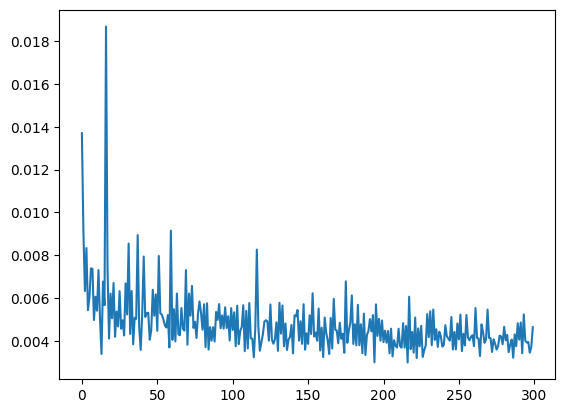

In [16]:
trainer.train(30000)

<Axes: xlabel='None', ylabel='None'>

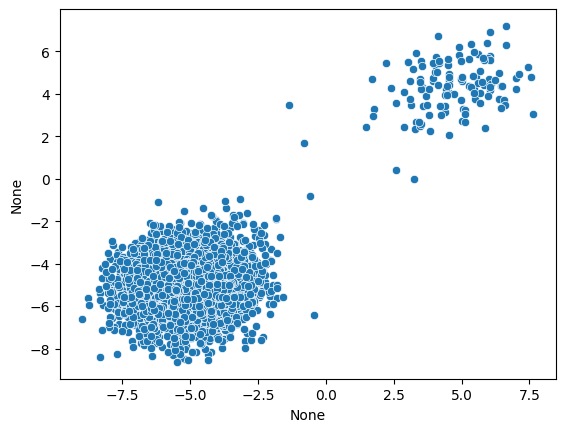

In [18]:
x_start = (torch.rand((5000, 2)) - 0.5) * 16.
generations = ncsn.sample(score_model, x_start)
sns.scatterplot(x=generations[:, 0], y=generations[:, 1])

### How to choose hyperparameters?
Details in the [paper](https://arxiv.org/abs/2006.09011).

**Technique 0**:
choose $\sigma_L$ in a way that $q_{\sigma_1}(x) \approx \pi(x)$.

**Technique 1** (Initial noise scale):
choose $\sigma_1$ to be as large as the maximum Euclidean distance between all pairs of training data points.

**Technique 2** (Other noise scales):
choose $\{\sigma_i\}$ as a geometric prograssion with a common ratio $\gamma$,
such that $\Phi(\sqrt{2D}(\gamma - 1) + 3 \gamma) - \Phi(\sqrt{2D}(\gamma - 1) - 3 \gamma) \approx 0.5$, where $D$ is a data dimensionality (should be large).

**Technique 3** (selecting $T$ and $\epsilon$):
choose $T$ as large as allowed by a computing budget and then select an
$\epsilon$ that makes equation below maximally close to 1.

$$
    f(\epsilon)
    =
    \left(
        1 - \frac{\epsilon}{\sigma_L^2}
    \right)^{2T}
    \left(
        \gamma^2
        -
        \frac{
            2 \epsilon
        }{
            \sigma_L^2
            -
            \sigma_L^2
            (1 - \frac{\epsilon}{\sigma_L^2})^2
        }
    \right)
    +
    \frac{
        2 \epsilon
    }{
        \sigma_L^2
        -
        \sigma_L^2
        (1 - \frac{\epsilon}{\sigma_L^2})^2
    }
$$